# Karim Kuserbaev

In [16]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import os

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool
import catboost
from catboost import * 
from catboost import datasets

from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import pytorch_tabular

from pytorch_tabular import TabularModel
from pytorch_tabular.models import CategoryEmbeddingModelConfig, GANDALFConfig, TabNetModelConfig
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    TrainerConfig,
)

Raw Data

In [6]:
train_df = pd.read_parquet('/kaggle/input/alfa-hack-dataset/train_data.pqt')
test_df = pd.read_parquet('/kaggle/input/alfa-hack-dataset/test_data.pqt')
print(train_df.shape), print(test_df.shape), print(train_df.isna().sum().sum()), print(test_df.isna().sum().sum())

(600000, 93)
(290120, 92)
9745768
4843836


(None, None, None, None)

In [7]:
X = train_df.drop(["id", "date"], axis=1)
y = train_df["end_cluster"]

x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42, shuffle=True)

In [8]:
cat_col_names = [
    "channel_code", "city", "city_type",
    "index_city_code", "ogrn_month", "ogrn_year",
    "okved", "segment", 'start_cluster'
]

num_col_names = x_train.select_dtypes(include='number').columns.tolist()

In [17]:
data_config = DataConfig(
    target=['end_cluster'],  # target should always be a list. Multi-targets are only supported for regression. Multi-Task Classification is not implemented
    continuous_cols=num_col_names,
    categorical_cols=cat_col_names,
    num_workers=4,
    normalize_continuous_features=True
    
)
trainer_config = TrainerConfig(
    auto_lr_find=True,  # Runs the LRFinder to automatically derive a learning rate
    batch_size=1024,
    max_epochs=100,
    early_stopping_patience=5,
    load_best=True,
    accelerator='gpu',
    devices=-1,
    min_epochs=10
)

optimizer_config = OptimizerConfig()

model_config = TabNetModelConfig(
    task="classification"
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    verbose=True
)
tabular_model.fit(train=x_train, validation=x_val)
# result = tabular_model.evaluate(test_df)
# pred_df = tabular_model.predict(test_df)
# tabular_model.save_model("examples/basic")
# loaded_model = TabularModel.load_model("examples/basic")

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /kaggle/working/saved_models exists and is not empty.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [1,0,0], thread: [0,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [1,0,0], thread: [3,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [1,0,0], thread: [5,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [1,0,0], thread: [6,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/usr/local/src/pytor

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [53]:
train_df = pd.read_parquet('/kaggle/input/alfa-hack-dataset/restored_train.pqt')
test_df = pd.read_parquet('/kaggle/input/alfahack-test/restored_test.pqt')
full_df = pd.read_parquet('/kaggle/input/alfahack-test/restored_full_dt.pqt')

cat_names = [
    "channel_code", "city", "city_type",
    "index_city_code", "ogrn_month", "ogrn_year",
    "okved", "segment", 'start_cluster'
]


merged_df = pd.concat([train_df, test_df], ignore_index=True)
for col in cat_names:
    full_df[col] = merged_df[col].copy()

train_df = full_df[:600000].copy()
test_df = full_df[600000:].copy()
test_df.drop(['end_cluster'], axis=1, inplace=True)
train_df.shape, test_df.shape

((600000, 93), (290120, 92))

In [2]:
train_df = pd.read_parquet('/kaggle/input/alfa-hack-dataset/train_data.pqt')
test_df = pd.read_parquet('/kaggle/input/alfa-hack-dataset/test_data.pqt')

In [3]:
train_df.shape, test_df.shape

((600000, 93), (290120, 92))

In [18]:
df = pd.read_parquet('/kaggle/input/alfahack-test/full_data.pqt')

In [21]:
label_encoders = {}

for col in cat_names:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

In [25]:
train_df = df[:600000].copy(deep=True)
test_df = df[600000:].copy(deep=True)
test_df.drop(['end_cluster'], axis=1, inplace=True)
train_df.shape, test_df.shape

((600000, 93), (290120, 92))

In [ ]:
%%time
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns[1:]

# KNNImputer(n_neighbors=2, weights='distance')
# IterativeImputer()

myImputer= KNNImputer(n_neighbors=2, weights='distance')
myImputer_data = myImputer.fit_transform(df[numerical_columns])

myImputer_data = pd.DataFrame(myImputer_data, columns = numerical_columns)
df[numerical_columns] = myImputer_data
df.to_parquet('restored_full_dt_knn.pqt')

In [38]:
train_df = pd.read_parquet('/kaggle/input/alfa-hack-dataset/train_data.pqt')
test_df = pd.read_parquet('/kaggle/input/alfa-hack-dataset/test_data.pqt')

## Импорт библиотек и настройки

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# pip install catboost

In [ ]:
!pip freeze | grep "numpy\|pandas\|lightgbm\|scikit-learn"

In [22]:
pd.options.display.max_rows = 93
pd.options.display.max_columns = 93

## Загрузка данных

In [ ]:
train_df = pd.read_parquet("/kaggle/input/alfahack-test/train_ready.pqt")
test_df = pd.read_parquet("/kaggle/input/alfahack-test/test_ready.pqt")

## Анализ

Размерность

In [ ]:
train_df.shape, test_df.shape

In [ ]:
train_df.head()

Количество строк без пропусков

In [ ]:
train_df.dropna().shape

In [ ]:
test_df.dropna().shape

In [ ]:
# train_df.drop(['index_city_code'], axis=1, inplace=True)
# test_df.drop(['index_city_code'], axis=1, inplace=True)

In [ ]:
test_df[test_df['date'] == 'month_6'].dropna().shape

## Предобработка

Обозначение категориальных признаков

In [15]:
cat_names = [
    "channel_code", "city", "city_type", 
     "index_city_code" ,"ogrn_month", "ogrn_year",
    "okved", "segment", "start_cluster"
]

In [110]:
label_encoders = {}

for col in cat_names:
    label_encoders[col] = LabelEncoder().fit(train_df[col])
    train_df[col] = label_encoders[col].transform(train_df[col])
    test_df[col] = label_encoders[col].transform(test_df[col])

In [ ]:
test_df[cat_names].isna().sum()

### Создаем выборки для валидации и обучения

Деление на обучающую и тестовую, исправляем дизбаланс классов, если не требуется, пропустить эти блоки до следующего текста

In [205]:
X = train_df.drop(["id", "date"], axis=1) # оставляю end_cluster чтобы получить пропорцию классов, а потом ниже удалю в коде
y = train_df["end_cluster"]

x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42, shuffle=True)

In [208]:
desired_proportions = {
    '{α}': 0.25,
    '{}': 0.16,
    '{other}': 0.16,
    '{α, η}': 0.07,
    '{α, γ}': 0.08,
    '{α, β}': 0.05,
    '{α, θ}': 0.05,
    '{α, ε}': 0.04,
    '{α, δ}': 0.02,
    '{α, ψ}': 0.01,
    '{α, μ}': 0.01,
    '{α, ε, η}': 0.02,
    '{α, ε, θ}': 0.03,
    '{α, λ}': 0.025,
    '{α, ε, ψ}': 0.01,
    '{λ}': 0.01,
    '{α, π}': 0.005
}

# Количество строк в X
num_rows_X = len(x_train)

# Создание нового DataFrame для добавления строк
new_rows = []

# Для каждого класса вычисляем количество строк, которые нужно добавить
for cls, proportion in desired_proportions.items():
    # Текущее количество строк для данного класса
    current_count = (x_train['end_cluster'] == cls).sum()
    # Желаемое количество строк для данного класса
    desired_count = int(proportion * num_rows_X * 1.9)
    # Сколько строк нужно добавить
    num_to_add = desired_count - current_count
    if num_to_add > 0:
        # Случайным образом выбираем строки из существующих данных
        additional_rows = x_train[x_train['end_cluster'] == cls].sample(n=num_to_add, replace=True)
        new_rows.append(additional_rows)

# Объединяем новые строки в DataFrame
new_data = pd.concat(new_rows)

# Добавляем новые строки к X
x_train = pd.concat([x_train, new_data], ignore_index=True)


In [209]:
print(x_train['end_cluster'].value_counts(normalize=True))

end_cluster
{α}          0.250001
{}           0.160000
{other}      0.160000
{α, γ}       0.080000
{α, η}       0.070000
{α, β}       0.050000
{α, θ}       0.050000
{α, ε}       0.040000
{α, ε, θ}    0.030000
{α, λ}       0.025000
{α, ε, η}    0.020000
{α, δ}       0.020000
{α, μ}       0.010000
{α, ψ}       0.010000
{α, ε, ψ}    0.010000
{λ}          0.010000
{α, π}       0.005000
Name: proportion, dtype: float64


In [154]:
# Calculate current class proportions
class_proportions = x_train['end_cluster'].value_counts(normalize=True)

# Identify underrepresented classes
underrepresented_classes = class_proportions[class_proportions < 0.08].index

# Create an empty list to store additional rows
additional_rows = []

# Calculate the number of additional rows needed for each underrepresented class
for class_label in underrepresented_classes:
    current_proportion = class_proportions[class_label]
    desired_proportion = 0.08
    current_count = (x_train['end_cluster'] == class_label).sum()
    desired_count = int(desired_proportion * len(train_df))
    additional_count = desired_count - current_count
    
    # Sample additional rows from the original dataset
    additional_samples = x_train[x_train['end_cluster'] == class_label].sample(n=additional_count, replace=True)
    additional_rows.append(additional_samples)

# Concatenate additional rows with the original dataframe
if additional_rows:
    x_train = pd.concat([x_train] + additional_rows, ignore_index=True)

# Verify the class proportions after balancing
print(x_train['end_cluster'].value_counts(normalize=True))

end_cluster
{α}          0.237582
{}           0.091356
{α, η}       0.044737
{α, θ}       0.044737
{α, γ}       0.044737
{α, μ}       0.044737
{α, ε, θ}    0.044737
{α, ε}       0.044737
{α, ε, η}    0.044737
{other}      0.044737
{α, β}       0.044737
{α, δ}       0.044737
{α, ψ}       0.044737
{α, λ}       0.044737
{α, ε, ψ}    0.044737
{λ}          0.044737
{α, π}       0.044737
Name: proportion, dtype: float64


In [210]:
y_train = x_train['end_cluster']
x_train = x_train.drop(['end_cluster'], axis=1)
x_val = x_val.drop(['end_cluster'], axis=1)

In [211]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1647120, 90), (1647120,), (120000, 90), (120000,))

Деление на тестовую и обучающую выборку без дизбаланса

In [137]:
X = train_df.drop(["id", "date", "end_cluster"], axis=1)
y = train_df["end_cluster"]

x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

## Обучение модели

Кросс-валидация для CatBoost (не нажимать если не разбираешься). Если не разбираешься, идти к следующему блоку текста

In [ ]:
from catboost import cv

params = {
    'loss_function': 'MultiClass',
    'iterations': 512,
    'random_seed': 43,
    'learning_rate': 0.1,
    'depth': 12,
    'task_type': 'GPU',
    'devices':'0'
}

cv_data = cv(
    params=params,
    pool=pool1,
    fold_count=5, # Разбивка выборки на 5 кусочков
    shuffle=True, # Перемешаем наши данные
    partition_random_seed=0,
    plot=True, # Никуда без визуализатора
    stratified=True, 
    verbose=30
)

In [ ]:
cv_data

In [ ]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])
print("Best validation Logloss score, stratified: {:.4f}+/-{:.3f} on step {}".format(
best_value, cv_data['test-Logloss-std'][best_iter], best_iter))

## Начало обучения

### XGBoost

In [ ]:
from xgboost import XGBClassifier

# Создание экземпляра классификатора с GPU поддержкой
xgb_classifier = XGBClassifier(
    tree_method='gpu_hist',  # Использование GPU для обучения
    predictor='gpu_predictor',
    device='CUDA'# Использование GPU для предсказания
)

# Обучение классификатора на обучающих данных
xgb_classifier.fit(x_train, y_train)

In [ ]:
model_path = 'xgboost_model.json'
xgb_classifier.save_model(model_path)

### CatBoostClassifier

model #28 with full raw data and raw catboost

In [212]:
model = CatBoostClassifier(iterations=1200,
                           depth=4,
                           learning_rate=0.2,
                           random_seed=43,
                           loss_function='MultiClass',
                           task_type="GPU",
                           devices='0',
                           early_stopping_rounds=20,
                          )

In [213]:
def train_catboost(model, x_train, y_train, x_val, y_val, cat_names):
    
    model.fit(
    x_train, y_train,
    cat_features=np.array(cat_names),
    eval_set=(x_val, y_val),
    verbose=50 # через сколько итераций выводить стату
    )
    model.save_model('catboost_model_28.json') # сохранение модели
    feature_importance = model.get_feature_importance(prettified=True) # датасет с важностью признаков
    
    return feature_importance

In [214]:
train_catboost(model, x_train, y_train, x_val, y_val, cat_names)

0:	learn: 2.1186163	test: 1.8510296	best: 1.8510296 (0)	total: 132ms	remaining: 2m 37s
50:	learn: 1.3277249	test: 1.0434895	best: 1.0434895 (50)	total: 5.94s	remaining: 2m 13s
100:	learn: 1.2568171	test: 1.0122215	best: 1.0122215 (100)	total: 11.6s	remaining: 2m 6s
150:	learn: 1.2128070	test: 0.9967529	best: 0.9967529 (150)	total: 17.3s	remaining: 2m
200:	learn: 1.1801403	test: 0.9875795	best: 0.9875795 (200)	total: 22.9s	remaining: 1m 53s
250:	learn: 1.1528378	test: 0.9795569	best: 0.9795569 (250)	total: 28.6s	remaining: 1m 48s
300:	learn: 1.1293406	test: 0.9738367	best: 0.9738367 (300)	total: 34.2s	remaining: 1m 42s
350:	learn: 1.1085839	test: 0.9683601	best: 0.9683601 (350)	total: 40s	remaining: 1m 36s
400:	learn: 1.0902287	test: 0.9639770	best: 0.9639770 (400)	total: 45.6s	remaining: 1m 30s
450:	learn: 1.0743647	test: 0.9599271	best: 0.9599271 (450)	total: 51.2s	remaining: 1m 25s
500:	learn: 1.0578473	test: 0.9558473	best: 0.9558473 (500)	total: 56.9s	remaining: 1m 19s
550:	learn: 

,Feature Id,Importances
0,start_cluster,10.829159
1,okved,7.074866
2,balance_amt_min,4.055083
3,city,3.938588
4,segment,3.061911
5,channel_code,3.033139
6,index_city_code,2.887194
7,sum_cred_e_oper_3m,2.698720
8,sum_of_paym_1y,2.363239
9,sum_cred_h_oper_3m,2.263880


Модель LGBM, блоки кода не нажимать чтобы не сбросилась model CatBoost. Я еще не тестил эту модель, переходи к метрикам

### LGBM

В качестве базовой модели возьмем LGBM обучим на всех признаках

In [ ]:
model = LGBMClassifier(verbosity=-1, random_state=42, n_jobs=-1)
model.fit(x_train, y_train)

### Метрики

Зададим функцию для взвешенной метрики roc auc

In [215]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

In [216]:
cluster_weights = pd.read_excel("/kaggle/input/alfa-hack-dataset/cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

Проверка работы модели

In [217]:
y_pred_proba = model.predict_proba(x_val)
y_pred_proba.shape

(120000, 17)

In [218]:
weighted_roc_auc(y_val, y_pred_proba, model.classes_, weights_dict)

0.9315362227866916

In [219]:
y_pred = model.predict(x_val)
y_pred = pd.DataFrame(y_pred)
y_pred[1] = y_val.reset_index(drop=True)

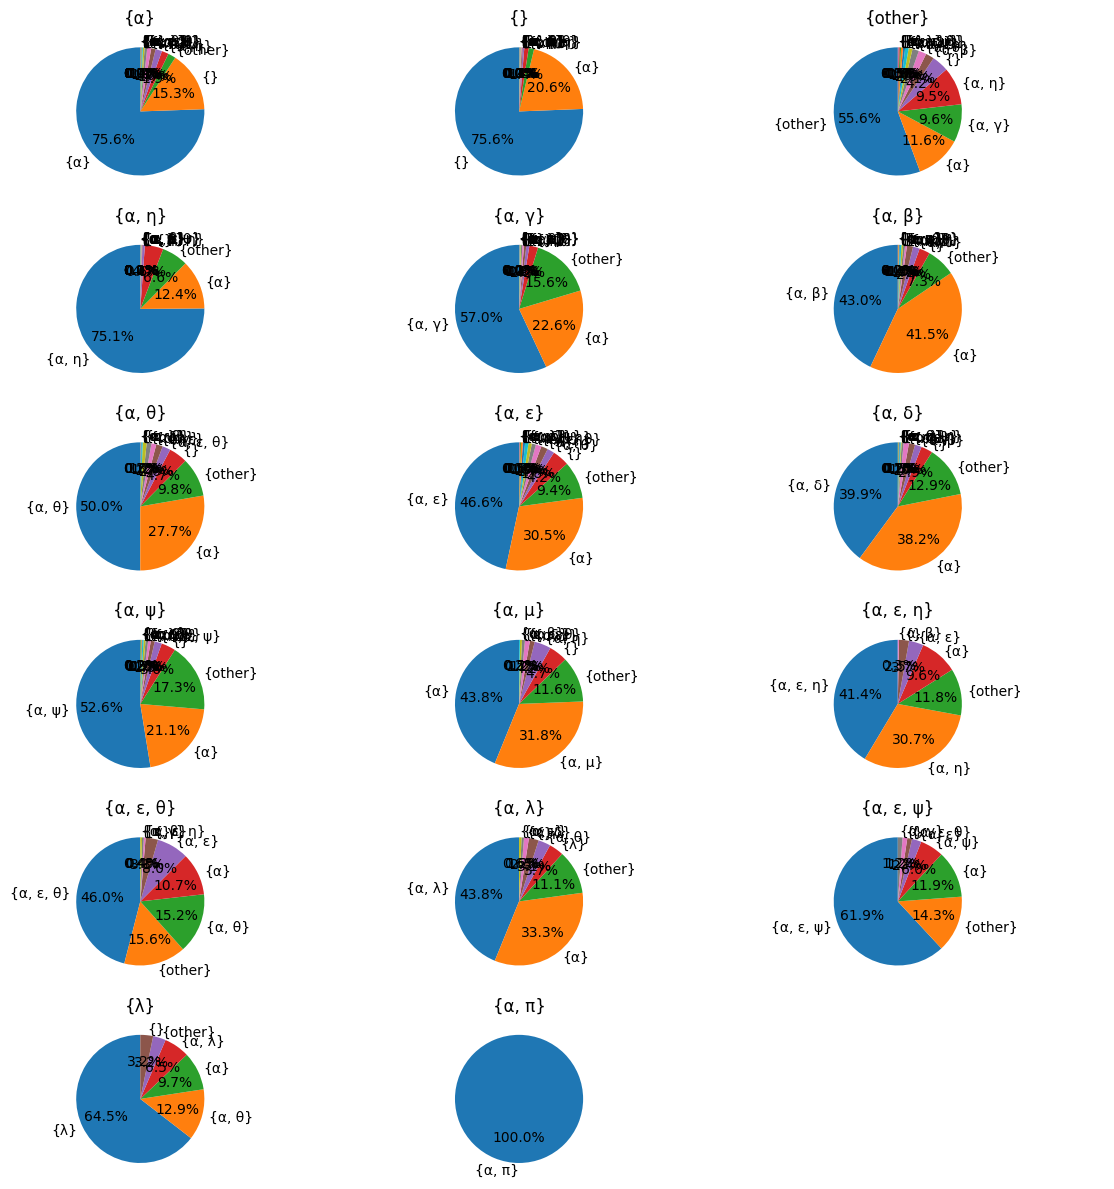

In [220]:
# Количество строк и столбцов в сетке графиков
rows = 6  # Можно изменить на нужное количество
cols = 3  # Можно изменить на нужное количество

# Создание сетки графиков
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

# Преобразование списка осей в одномерный массив
axes_flat = axes.flatten()

# Проход по каждому классу и создание круговой диаграммы на соответствующем месте в сетке
for i, clas in enumerate(list_of_classes):
    data = y_pred[y_pred[1] == clas][0].value_counts()
    ax = axes_flat[i]
    ax.pie(data.values, labels=data.keys(), autopct='%1.1f%%', startangle=90)
    ax.set_title(f'{clas}')

# Сокрытие ненужных осей в сетке
for j in range(len(list_of_classes), rows * cols):
    axes_flat[j].axis('off')

plt.tight_layout()
plt.show()

## Прогноз на тестовой выборке

In [221]:
sample_submission_df = pd.read_csv("/kaggle/input/sample-submission/sample_submission.csv") # поменять на свой
last_m_test_df = test_df[test_df["date"] == "month_6"]
last_m_test_df = last_m_test_df.drop(["id", "date"], axis=1)

pool2 = Pool(data=last_m_test_df, cat_features=np.array(cat_names))

test_pred_proba = model.predict_proba(pool2) # last_m_test_df
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=model.classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("catboost_submission_27.csv", index=False) # сохранение сабмишна

In [222]:
sample_submission_df.shape # если (100000, 18), то все правильно. Если нет - надо писать Кариму и спрашивать(

(100000, 18)

In [223]:
sample_submission_df

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.014303,0.018424,0.151707,0.053187,0.018014,0.000125,0.003421,0.000449,0.193588,0.004273,0.022766,0.001492,0.021659,3.367419e-08,0.014064,0.482527,8.759669e-09
1,200001,0.012629,0.674625,0.003193,0.002223,0.001897,0.003289,0.004188,0.000008,0.007333,0.007826,0.010509,0.004665,0.001049,5.240701e-10,0.000386,0.257852,8.329043e-03
2,200002,0.481511,0.000616,0.000730,0.100159,0.010879,0.000039,0.001201,0.021311,0.082130,0.021521,0.114474,0.005424,0.000281,9.632015e-10,0.134652,0.025071,4.517022e-07
3,200003,0.049884,0.642459,0.000880,0.001307,0.000690,0.002403,0.001410,0.000492,0.004953,0.029719,0.064755,0.003025,0.002117,1.885310e-09,0.001546,0.194357,2.248670e-06
4,200004,0.372071,0.138722,0.056496,0.044538,0.002940,0.010943,0.000557,0.002627,0.027682,0.041938,0.081069,0.002903,0.020299,1.259919e-08,0.005762,0.191453,1.394698e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,299995,0.095016,0.323646,0.006504,0.018622,0.004090,0.000070,0.051357,0.000002,0.044831,0.002097,0.006728,0.016742,0.000623,2.529407e-07,0.007211,0.421773,6.875184e-04
99996,299996,0.056619,0.056641,0.037120,0.065158,0.027252,0.002970,0.009264,0.000289,0.045814,0.005500,0.064352,0.159427,0.005887,6.417675e-07,0.010462,0.451337,1.906015e-03
99997,299997,0.064224,0.028922,0.106434,0.060274,0.031406,0.000382,0.009480,0.005388,0.093442,0.015498,0.042265,0.006646,0.011964,8.342581e-09,0.049158,0.474518,1.092775e-07
99998,299998,0.402105,0.122330,0.024685,0.044250,0.005713,0.006421,0.002699,0.017147,0.025836,0.050370,0.057008,0.003340,0.007916,9.057212e-09,0.015892,0.213980,3.083256e-04
